# **Core Stock Data Preprocessing Notebook**
## In this notebook we will preprocess our core stock data, scaling and performing PCA (Principle Component Analysis) as well as set up lag and rolling windows.  We will also create new features to help our forthcoming baseline models in the upcoming notebooks.

#### Let's start by bringing in the libraries and logic necessary for reading in our file.

In [1]:

import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy import stats



#### Now let's read in our data that we need for this notebook.

In [2]:
# Now let's access the main core_stock_data.csv file
csv_path = os.path.join(project_root, 'data', 'core_stock_data.csv')
core_stock_data = pd.read_csv(csv_path, parse_dates=['Date'], index_col= 'Date')
core_stock_data.head()
core_stock_data.shape

(13650, 27)

#### Before we get started I want to address outliers in our data.  I will address this by calculating the z_score and defining the threshold for outliers based on how many std (standard deviations) away from the mean the data points are, then display how many outliers we have per feature.  I can then adjust the threshold as necessary before filtering the dataframe to remove them.

In [3]:
numeric_cols = core_stock_data.select_dtypes(include = [np.number])
z_scores = np.abs(stats.zscore(numeric_cols))
threshold = 3 # Common threshold starting std modifier

outliers = (z_scores > threshold)

print(outliers.sum(axis = 0))


Close_core           29
Volume_core         415
Open_core            27
High_core            26
Low_core             27
SMA_core              0
EMA_core              5
RMA_core            229
RSI_core              0
BBM_core              0
BBU_core              0
BBL_core              1
MACD_core           308
MACD_Signal_core    304
MACD_Hist_core      310
ADX_14_core          69
CCI_20_core          50
ATR_14_core         243
Stoch_K_core          0
Stoch_D_core          0
Momentum_1_core     265
Momentum_3_core     264
Momentum_7_core     284
Momentum_30_core    315
Momentum_50_core    295
OBV_core            406
dtype: int64


#### Our Volume feature has an alarming amount of outliers, and as we know Volume is used to calculate a lot of our other other custom features.  We will need to normalize the Volume feature so we can figure out what's going on.  Let's take a closer look with a plot.

In [4]:
# We will look at the distribution of Volume here.
fig = px.histogram(core_stock_data, x = 'Volume_core',
                nbins = 100,
                title = 'Volume Distribution',
                labels = {'Volume' : 'Trading Volume'},
                marginal = 'box',
                histnorm = 'percent')

fig.update_layout(bargap = 0.1,
                xaxis_title = 'Volume',
                yaxis_title = 'Percentage',
                showlegend = False)

fig.show()

#### There is a heavy right-skew, which shows that we have a positive skew.  This means that there are a few exceptionally high data values (our outliers) that are distorting our statistical measures.  We will look to normalize this data a bit so our statistics and custom features are calculated appropriately, and will do so using a log transform method.

In [5]:
def volume_log_transform(core_stock_data):
    core_stock_data['Volume_core'] = np.log1p(core_stock_data['Volume_core'])
    return core_stock_data

core_stock_data = volume_log_transform(core_stock_data)



#### Now we will replot the Volume feature to see how it looks after the log transform.

In [6]:
fig = px.histogram(core_stock_data,
                x = 'Volume_core',
                marginal = 'box',
                title = 'Volume Distribution After Log Transformation',
                )

fig.update_layout(bargap = 0.2)

fig.show()

#### This is much better, there are few fewer outliers shown in the top part of the plot and you can see the bell curve shape for our Volume feature.

#### Let's now apply this method to all of our numeric columns, also applying z_scores as well after the log transform.  We will then view each feature's respective distribution from the log transform.

In [7]:
# We will be inserting logic to replace any 0 digits in our data with an extremely small number, the log transform doesn't work well with 0s or negative numbers.
def log_transform_and_zscore(dataframe):
    numeric_cols = dataframe.select_dtypes(include = [np.number])
    
    for col in numeric_cols:
        numeric_cols[col] = numeric_cols[col].apply(lambda x : 1e-10 if x <= 0 else x)
    
    log_transformed_data = np.log1p(numeric_cols)
    
    z_scores = np.abs(stats.zscore(log_transformed_data))
    
    threshold = 3
    
    outliers = (z_scores >= threshold)
    
    outliers_summary = outliers.sum(axis = 0)
    
    filtered_data = log_transformed_data[(~outliers).all(axis = 1)]
        
    return filtered_data, outliers_summary

transformed_data, outliers_summary = log_transform_and_zscore(core_stock_data)

print(outliers_summary)



Close_core          197
Volume_core           1
Open_core           197
High_core           196
Low_core            199
SMA_core            180
EMA_core            205
RMA_core            236
RSI_core            138
BBM_core            180
BBU_core            185
BBL_core            152
MACD_core            67
MACD_Signal_core     64
MACD_Hist_core      239
ADX_14_core          24
CCI_20_core           0
ATR_14_core           0
Stoch_K_core        265
Stoch_D_core        138
Momentum_1_core     144
Momentum_3_core      65
Momentum_7_core      30
Momentum_30_core      0
Momentum_50_core      0
OBV_core              0
dtype: int64


#### Much better progress, our Volume feature has been almost entirely rid of outliers and great progress on almost every single other feature.  The only downside is that outliers were actually found in two features (Stoch_K_core, Stoch_D_core).  This is something that is plausible when the log transform is performed and the data is 'spread out', the outliers that weren't apparent before now are reported.  Since the outlier value quantity is extremely low though at this point for just two features and everything else looks fine we will move forward at this time.

#### Now we will create new custom features for our core data, as well as set up the lag windows and features here.

In [8]:
# We will need to create a temp variable since we are making so many custom features, it will otherwise create a PerformanceWarning since when we execute the cell on our main df its too much at once.
# By storing all the custom features to a temp variable and then concatenating them in a separate step it takes the pressure off in the execute phase.
new_temp_columns = pd.DataFrame(index = core_stock_data.index)

# Now let's create a variable to house our features we want to create lag features for.
features_to_lag = ['Open_core', 'High_core', 'Low_core', 'Volume_core','Close_core', 'EMA_core', 'SMA_core', 'RMA_core', 'RSI_core', 'BBM_core', 'BBL_core', 'BBU_core', 'MACD_core', 'MACD_Signal_core', 'MACD_Hist_core', 'ADX_14_core', 'CCI_20_core', 'ATR_14_core', 'Stoch_K_core', 'Stoch_D_core', 'Momentum_1_core', 'Momentum_3_core', 'Momentum_7_core', 'Momentum_30_core', 'Momentum_50_core', 'OBV_core']

# Now we apply the lag windows with a small 3-day window size.
for feature in features_to_lag:
    for lag in range(1,4):
        new_temp_columns[f'{feature}_Lag_{lag}'] = core_stock_data[feature].shift(lag)

# Great, now from these new lag-based features let's expand on it further by creating some custom features using our existing ones.
new_temp_columns['Close_Lag_Avg_1_3_core'] = new_temp_columns[['Close_core_Lag_1', 'Close_core_Lag_2', 'Close_core_Lag_3']].mean(axis = 1)
new_temp_columns['Close_Lag_Std_1_3_core'] = new_temp_columns[['Close_core_Lag_1', 'Close_core_Lag_2', 'Close_core_Lag_3']].std(axis = 1)

new_temp_columns['Open_Lag_Avg_1_3_core'] = new_temp_columns[['Open_core_Lag_1', 'Open_core_Lag_2', 'Open_core_Lag_3']].mean(axis = 1)
new_temp_columns['Open_Lag_Std_1_3_core'] = new_temp_columns[['Open_core_Lag_1', 'Open_core_Lag_2', 'Open_core_Lag_3']].std(axis = 1)

new_temp_columns['High_Lag_Avg_1_3_core'] = new_temp_columns[['High_core_Lag_1', 'High_core_Lag_2', 'High_core_Lag_3']].mean(axis = 1)
new_temp_columns['High_Lag_Std_1_3_core'] = new_temp_columns[['High_core_Lag_1', 'High_core_Lag_2', 'High_core_Lag_3']].std(axis = 1)

new_temp_columns['Low_Lag_Avg_1_3_core'] = new_temp_columns[['Low_core_Lag_1', 'Low_core_Lag_2', 'Low_core_Lag_3']].mean(axis = 1)
new_temp_columns['Low_Lag_Std_1_3_core'] = new_temp_columns[['Low_core_Lag_1', 'Low_core_Lag_2', 'Low_core_Lag_3']].std(axis = 1)

new_temp_columns['Volume_Lag_Avg_1_3_core'] = new_temp_columns[['Volume_core_Lag_1', 'Volume_core_Lag_2', 'Volume_core_Lag_3']].mean(axis = 1)
new_temp_columns['Volume_Lag_Std_1_3_core'] = new_temp_columns[['Volume_core_Lag_1', 'Volume_core_Lag_2', 'Volume_core_Lag_3']].std(axis = 1)

new_temp_columns['EMA_Lag_Avg_1_3_core'] = new_temp_columns[['EMA_core_Lag_1', 'EMA_core_Lag_2', 'EMA_core_Lag_3']].mean(axis = 1)
new_temp_columns['EMA_Lag_Std_1_3_core'] = new_temp_columns[['EMA_core_Lag_1', 'EMA_core_Lag_2', 'EMA_core_Lag_3']].std(axis = 1)

new_temp_columns['SMA_Lag_Avg_1_3_core'] = new_temp_columns[['SMA_core_Lag_1', 'SMA_core_Lag_2', 'SMA_core_Lag_3']].mean(axis = 1)
new_temp_columns['SMA_Lag_Std_1_3_core'] = new_temp_columns[['SMA_core_Lag_1', 'SMA_core_Lag_2', 'SMA_core_Lag_3']].std(axis = 1)

new_temp_columns['RMA_Lag_Avg_1_3_core'] = new_temp_columns[['RMA_core_Lag_1', 'RMA_core_Lag_2', 'RMA_core_Lag_3']].mean(axis = 1)
new_temp_columns['RMA_Lag_Std_1_3_core'] = new_temp_columns[['RMA_core_Lag_1', 'RMA_core_Lag_2', 'RMA_core_Lag_3']].std(axis = 1)

new_temp_columns['RSI_Lag_Avg_1_3_core'] = new_temp_columns[['RSI_core_Lag_1', 'RSI_core_Lag_2', 'RSI_core_Lag_3']].mean(axis = 1)
new_temp_columns['RSI_Lag_Std_1_3_core'] = new_temp_columns[['RSI_core_Lag_1', 'RSI_core_Lag_2', 'RSI_core_Lag_3']].std(axis = 1)

new_temp_columns['BBM_Lag_Avg_1_3_core'] = new_temp_columns[['BBM_core_Lag_1', 'BBM_core_Lag_2', 'BBM_core_Lag_3']].mean(axis = 1)
new_temp_columns['BBM_Lag_Std_1_3_core'] = new_temp_columns[['BBM_core_Lag_1', 'BBM_core_Lag_2', 'BBM_core_Lag_3']].std(axis = 1)

new_temp_columns['BBU_Lag_Avg_1_3_core'] = new_temp_columns[['BBU_core_Lag_1', 'BBU_core_Lag_2', 'BBU_core_Lag_3']].mean(axis = 1)
new_temp_columns['BBU_Lag_Std_1_3_core'] = new_temp_columns[['BBU_core_Lag_1', 'BBU_core_Lag_2', 'BBU_core_Lag_3']].std(axis = 1)

new_temp_columns['BBL_Lag_Avg_1_3_core'] = new_temp_columns[['BBL_core_Lag_1', 'BBL_core_Lag_2', 'BBL_core_Lag_3']].mean(axis = 1)
new_temp_columns['BBL_Lag_Std_1_3_core'] = new_temp_columns[['BBL_core_Lag_1', 'BBL_core_Lag_2', 'BBL_core_Lag_3']].std(axis = 1)

new_temp_columns['Stoch_K_Lag_Avg_1_3_core'] = new_temp_columns[['Stoch_K_core_Lag_1', 'Stoch_K_core_Lag_2', 'Stoch_K_core_Lag_3']].mean(axis = 1)
new_temp_columns['Stoch_K_Lag_Std_1_3_core'] = new_temp_columns[['Stoch_K_core_Lag_1', 'Stoch_K_core_Lag_2', 'Stoch_K_core_Lag_3']].std(axis = 1)

new_temp_columns['Stoch_D_Lag_Avg_1_3_core'] = new_temp_columns[['Stoch_D_core_Lag_1', 'Stoch_D_core_Lag_2', 'Stoch_D_core_Lag_3']].mean(axis = 1)
new_temp_columns['Stoch_D_Lag_Std_1_3_core'] = new_temp_columns[['Stoch_D_core_Lag_1', 'Stoch_D_core_Lag_2', 'Stoch_D_core_Lag_3']].std(axis = 1)

new_temp_columns['MACD_Lag_Avg_1_3_core'] = new_temp_columns[['MACD_core_Lag_1', 'MACD_core_Lag_2', 'MACD_core_Lag_3']].mean(axis = 1)
new_temp_columns['MACD_Lag_Std_1_3_core'] = new_temp_columns[['MACD_core_Lag_1', 'MACD_core_Lag_2', 'MACD_core_Lag_3']].std(axis = 1)

new_temp_columns['MACD_Signal_Lag_Avg_1_3_core'] = new_temp_columns[['MACD_Signal_core_Lag_1', 'MACD_Signal_core_Lag_2', 'MACD_Signal_core_Lag_3']].mean(axis = 1)
new_temp_columns['MACD_Signal_Lag_Std_1_3_core'] = new_temp_columns[['MACD_Signal_core_Lag_1', 'MACD_Signal_core_Lag_2', 'MACD_Signal_core_Lag_3']].std(axis = 1)

new_temp_columns['MACD_Hist_Avg_1_3_core'] = new_temp_columns[['MACD_Hist_core_Lag_1', 'MACD_Hist_core_Lag_2', 'MACD_Hist_core_Lag_3']].mean(axis = 1)
new_temp_columns['MACD_Hist_Lag_Std_1_3_core'] = new_temp_columns[['MACD_Hist_core_Lag_1', 'MACD_Hist_core_Lag_2', 'MACD_Hist_core_Lag_3']].std(axis = 1)

new_temp_columns['ADX_14_Lag_Avg_1_3_core'] = new_temp_columns[['ADX_14_core_Lag_1', 'ADX_14_core_Lag_2', 'ADX_14_core_Lag_3']].mean(axis = 1)
new_temp_columns['ADX_14_Lag_Std_1_3_core'] = new_temp_columns[['ADX_14_core_Lag_1', 'ADX_14_core_Lag_2', 'ADX_14_core_Lag_3']].std(axis = 1)

new_temp_columns['CCI_20_Lag_Avg_1_3_core'] = new_temp_columns[['CCI_20_core_Lag_1', 'CCI_20_core_Lag_2', 'CCI_20_core_Lag_3']].mean(axis = 1)
new_temp_columns['CCI_20_Lag_Std_1_3_core'] = new_temp_columns[['CCI_20_core_Lag_1', 'CCI_20_core_Lag_2', 'CCI_20_core_Lag_3']].std(axis = 1)

new_temp_columns['ATR_14_Lag_Avg_1_3_core'] = new_temp_columns[['ATR_14_core_Lag_1', 'ATR_14_core_Lag_2', 'ATR_14_core_Lag_3']].mean(axis = 1)
new_temp_columns['ATR_14_Lag_Std_1_3_core'] = new_temp_columns[['ATR_14_core_Lag_1', 'ATR_14_core_Lag_2', 'ATR_14_core_Lag_3']].std(axis = 1)

new_temp_columns['Momentum_1_Lag_Avg_1_3_core'] = new_temp_columns[['Momentum_1_core_Lag_1', 'Momentum_1_core_Lag_2', 'Momentum_1_core_Lag_3']].mean(axis = 1)
new_temp_columns['Momentum_1_Lag_Std_1_3_core'] = new_temp_columns[['Momentum_1_core_Lag_1', 'Momentum_1_core_Lag_2', 'Momentum_1_core_Lag_3']].std(axis = 1)

new_temp_columns['Momentum_3_Lag_Avg_1_3_core'] = new_temp_columns[['Momentum_3_core_Lag_1', 'Momentum_3_core_Lag_2', 'Momentum_3_core_Lag_3']].mean(axis = 1)
new_temp_columns['Momentum_3_Lag_Std_1_3_core'] = new_temp_columns[['Momentum_3_core_Lag_1', 'Momentum_3_core_Lag_2', 'Momentum_3_core_Lag_3']].std(axis = 1)

new_temp_columns['Momentum_7_Lag_Avg_1_3_core'] = new_temp_columns[['Momentum_7_core_Lag_1', 'Momentum_7_core_Lag_2', 'Momentum_7_core_Lag_3']].mean(axis = 1)
new_temp_columns['Momentum_7_Lag_Std_1_3_core'] = new_temp_columns[['Momentum_7_core_Lag_1', 'Momentum_7_core_Lag_2', 'Momentum_7_core_Lag_3']].std(axis = 1)

new_temp_columns['Momentum_30_Lag_Avg_1_3_core'] = new_temp_columns[['Momentum_30_core_Lag_1', 'Momentum_30_core_Lag_2', 'Momentum_30_core_Lag_3']].mean(axis = 1)
new_temp_columns['Momentum_30_Lag_Std_1_3_core'] = new_temp_columns[['Momentum_30_core_Lag_1', 'Momentum_30_core_Lag_2', 'Momentum_30_core_Lag_3']].std(axis = 1)

new_temp_columns['Momentum_50_Lag_Avg_1_3_core'] = new_temp_columns[['Momentum_50_core_Lag_1', 'Momentum_50_core_Lag_2', 'Momentum_50_core_Lag_3']].mean(axis = 1)
new_temp_columns['Momentum_50_Lag_Std_1_3_core'] = new_temp_columns[['Momentum_50_core_Lag_1', 'Momentum_50_core_Lag_2', 'Momentum_50_core_Lag_3']].std(axis = 1)

new_temp_columns['OBV_Lag_Avg_1_3_core'] = new_temp_columns[['OBV_core_Lag_1', 'OBV_core_Lag_2', 'OBV_core_Lag_3']].mean(axis = 1)
new_temp_columns['OBV_Lag_Std_1_3_core'] = new_temp_columns[['OBV_core_Lag_1', 'OBV_core_Lag_2', 'OBV_core_Lag_3']].std(axis = 1)

new_temp_columns['Close_Lag_Avg_1_3_core'] = new_temp_columns[['Close_core_Lag_1', 'Close_core_Lag_2', 'Close_core_Lag_3']].mean(axis = 1)
new_temp_columns['Close_Lag_Std_1_3_core'] = new_temp_columns[['Close_core_Lag_1', 'Close_core_Lag_2', 'Close_core_Lag_3']].std(axis = 1)

new_temp_columns['Diff_Close_EMA_core'] = core_stock_data['Close_core'] - core_stock_data['EMA_core']
new_temp_columns['Ratio_Close_EMA_core'] = core_stock_data['Close_core'] / core_stock_data['EMA_core']

# Now we can concatenate onto our original core_stock_data.
core_stock_data = pd.concat([core_stock_data, new_temp_columns], axis = 1)

print(core_stock_data.head())

#print(core_stock_data.head(10))
print(core_stock_data.isnull().sum())


            Close_core  Volume_core  Open_core  High_core   Low_core  \
Date                                                                   
2019-03-14   45.932499    18.362183  45.974998  46.025002  45.639999   
2019-03-15   46.529999    18.866466  46.212502  46.832500  45.935001   
2019-03-18   47.005001    18.468320  46.450001  47.097500  46.447498   
2019-03-19   46.632500    18.656429  47.087502  47.247501  46.480000   
2019-03-20   47.040001    18.636927  46.557499  47.372501  46.182499   

            SMA_core   EMA_core  RMA_core  RSI_core  BBM_core  ...  \
Date                                                           ...   
2019-03-14   48.9614  45.932499  1.000000  67.22464   48.9614  ...   
2019-03-15   48.9614  45.955930  1.012492  67.22464   48.9614  ...   
2019-03-18   48.9614  45.997070  1.021913  67.22464   48.9614  ...   
2019-03-19   48.9614  46.021989  1.013266  67.22464   48.9614  ...   
2019-03-20   48.9614  46.061911  1.021234  67.22464   48.9614  ...   

    

C:\Users\ryanm\AppData\Local\Temp\ipykernel_18388\2640678207.py:47: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\ryanm\AppData\Local\Temp\ipykernel_18388\2640678207.py:48: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\ryanm\AppData\Local\Temp\ipykernel_18388\2640678207.py:50: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragment

#### Looks like with the creation of our new features we have some missing values to take care of.  Let's address those real quick before we move on.

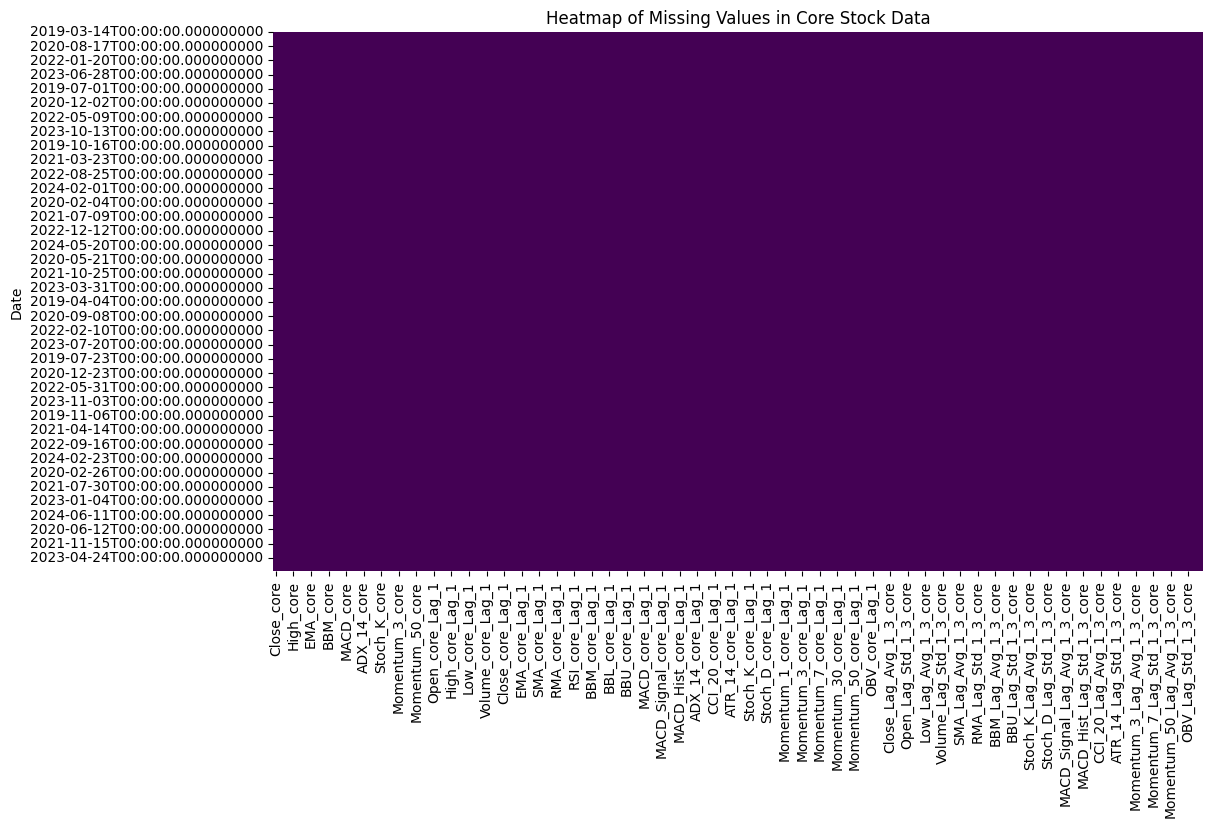

In [9]:
plt.figure(figsize = (12,7))
sns.heatmap(core_stock_data.isna(), cbar = False, cmap = 'viridis')
plt.title('Heatmap of Missing Values in Core Stock Data')
plt.show()

#### When looking above it really is hard to tell since each row that has missing values is only missing between 1-3 values.  There are only a few values to fill, most likely due to the overlapping of the lag windows.  Let's create a quick function to impute those values, and then fill each feature column that contained one.  We will follow with a quick check to see that there are no more remaining missing values.

In [13]:
def fill_missing_vals(df):
    df.ffill(inplace = True)
    df.bfill(inplace = True)
    df.interpolate(method = 'linear', inplace = True)
    
    return df

core_stock_data = core_stock_data.copy()

for col in core_stock_data.columns:
    if core_stock_data[col].isnull().any():
        core_stock_data.loc[:, col] = fill_missing_vals(core_stock_data[[col]])[col]



print(core_stock_data.isna().sum())

Close_core                      0
Volume_core                     0
Open_core                       0
High_core                       0
Low_core                        0
                               ..
Momentum_50_Lag_Std_1_3_core    0
OBV_Lag_Avg_1_3_core            0
OBV_Lag_Std_1_3_core            0
Diff_Close_EMA_core             0
Ratio_Close_EMA_core            0
Length: 159, dtype: int64


# Looks good, now we can move on to scaling our new dataframe.

In [14]:
# We will need to temporarily drop the Ticker column as it is a float value.  We will create a variable for it now, and use it later to bring it back when needed.
tickers = core_stock_data['Ticker'].values
core_stock_data = core_stock_data.drop(columns = ['Ticker'])

# Initiate the scaler and transform the data.
scaler = StandardScaler()
scaled_data = scaler.fit_transform(core_stock_data)
core_stock_scaled = pd.DataFrame(scaled_data, index = core_stock_data.index, columns = core_stock_data.columns)
print(core_stock_scaled.head())

            Close_core  Volume_core  Open_core  High_core  Low_core  SMA_core  \
Date                                                                            
2019-03-14   -1.030291     0.728372  -1.029555  -1.035260 -1.026614 -1.015614   
2019-03-15   -1.025059     1.089768  -1.027475  -1.028266 -1.024000 -1.015614   
2019-03-18   -1.020898     0.804435  -1.025395  -1.025970 -1.019458 -1.015614   
2019-03-19   -1.024161     0.939245  -1.019811  -1.024671 -1.019170 -1.015614   
2019-03-20   -1.020592     0.925268  -1.024453  -1.023589 -1.021807 -1.015614   

            EMA_core  RMA_core  RSI_core  BBM_core  ...  \
Date                                                ...   
2019-03-14 -1.026934 -0.263104  0.782535 -1.015614  ...   
2019-03-15 -1.026724 -0.113385  0.782535 -1.015614  ...   
2019-03-18 -1.026356 -0.000468  0.782535 -1.015614  ...   
2019-03-19 -1.026133 -0.104110  0.782535 -1.015614  ...   
2019-03-20 -1.025776 -0.008602  0.782535 -1.015614  ...   

            Moment

#### This looks good, let's save it so we can use later on in our baseline modeling notebook.

In [17]:
# Need to convert the PCA_transformed data back to a dataframe and add back in our Ticker column first
core_stock_scaled['Ticker'] = tickers

core_stock_scaled.to_csv(os.path.join(project_root, 'data', 'core_stock_preprocessed.csv'), index = False)
